In [1]:
import fwiVis.fwiVis as fv #somehow not including updates to code? 

import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
import zarr #Didn't build into the env, needed to run "mamba install -c conda-forge zarr" took awhile, and was killed w/out mamba. Wait, it actually only worked with pip? 
import rasterio
from rasterio.plot import plotting_extent
import datetime as dt
from datetime import timedelta, date

In [36]:
files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map,  path_s3 = "veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
st_dict = stations[['Lat', 'Lon']].to_dict('records')
#stations
#files

foi = [{"Lat":38.586 , 
        "Lon":-120.537833 
    
}]
foi = pd.DataFrame(foi)
st_cls = fv.closest(st_dict, foi)
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

#gdf = gdf.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
#gdf['t'] = gdf['t'].astype('datetime64[ns]')

#full_fr = fv.fr_st_merge(gdf, st, sub = True)
#full_fr
st

## Subset to relvatn dates (from CAL FIRE)

# Start 08/14/21 6:54 PM,  End 10/21/21 8:18AM

st = st[st.time > "2021-08-01 12:00:00"]

st = st[st.time < "2021-09-30 12:00:00"]

fireID = '0'
gdf = fv.load_large_fire(fireID, year = "2021", path_region="Caldor")
gdf['timediff'] = gdf.t.astype("datetime64[ns]") - pd.to_datetime("2021-08-14 18:00:00")
gdf['timediff'] = gdf.timediff.astype("int")
#gdf["t"] = gdf["t"].astype("str")
gdf.t.astype("datetime64[ns]")
gdf = gdf.sort_values(by = ["t"])

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/
The closest station is 23.48698806042275 km away.


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:127: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:127: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:372: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:373: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 

In [37]:
## Read in Caldor pixels individually. 

caldor_perimeters = gpd.read_file('/projects/shared-buckets/ashiklom/CALDOR_sbs/caldor_perimeter_ts.geojson')
caldor_pixels = gpd.read_file('/projects/shared-buckets/ashiklom/CALDOR_sbs/caldor_pixel_ts.geojson')
goes = pd.read_csv('/projects/shared-buckets/ashiklom/CALDOR_sbs/GOES17_CaldorFire.csv')
goes = gpd.GeoDataFrame(goes, 
                        geometry=gpd.points_from_xy(goes.lon, goes.lat),
                       crs='EPSG:4236')
goes.to_crs(caldor_pixels.crs,inplace=True)
goes['dt'] = pd.to_datetime(goes['date'])

In [4]:
caldor_pixels

,t,x,y,frp,DS,DT,ampm,datetime,sat,geometry
0,2021-08-15,-1.766510e+06,-492937.898719,6.56,0.557171,0.334839,AM,2021-08-15 09:12:00,SNPP,POINT (717536.634 4274140.831)
1,2021-08-15,-1.766122e+06,-492541.472528,4.26,0.656101,0.496794,AM,2021-08-15 10:48:00,SNPP,POINT (717812.547 4274625.696)
2,2021-08-15,-1.766183e+06,-493051.925432,6.56,0.557053,0.334672,AM,2021-08-15 09:12:00,SNPP,POINT (717884.316 4274120.439)
3,2021-08-15,-1.765735e+06,-492414.876525,2.20,0.557171,0.334839,AM,2021-08-15 09:12:00,SNPP,POINT (718156.310 4274851.820)
4,2021-08-15,-1.765918e+06,-492964.465336,10.45,0.557171,0.334839,AM,2021-08-15 09:12:00,SNPP,POINT (718119.067 4274275.892)
...,...,...,...,...,...,...,...,...,...,...
20229,2021-10-04,-1.725220e+06,-484594.649071,1.27,0.417050,0.523834,AM,2021-10-04 10:12:00,SNPP,POINT (755531.901 4293319.875)
20230,2021-10-05,-1.726815e+06,-487507.366349,1.96,0.361919,0.386084,AM,2021-10-05 09:54:00,SNPP,POINT (754729.524 4290097.268)
20231,2021-10-05,-1.723615e+06,-486988.489689,1.22,0.362010,0.386292,AM,2021-10-05 09:54:00,SNPP,POINT (757707.465 4291461.243)
20232,2021-10-05,-1.725065e+06,-484626.566749,0.58,0.361931,0.386113,AM,2021-10-05 09:54:00,SNPP,POINT (755690.505 4293331.209)


In [33]:
## Align caldor pixels with perimeter

caldor_pixels.t = caldor_pixels.t.astype("str") ## Maybe I don't even need these? 
#caldor_pixels.t

0        2021-08-15 00:00:00
1        2021-08-15 00:00:00
2        2021-08-15 00:00:00
3        2021-08-15 00:00:00
4        2021-08-15 00:00:00
                ...         
20229    2021-10-04 00:00:00
20230    2021-10-05 00:00:00
20231    2021-10-05 00:00:00
20232    2021-10-05 00:00:00
20233    2021-10-05 00:00:00
Name: t, Length: 20234, dtype: object

In [53]:
st = st.rename(columns={"time":"t"})
full_fr = pd.merge(gdf,st, on = "t", how = "outer")
full_fr = full_fr.sort_values(by = ['t'])

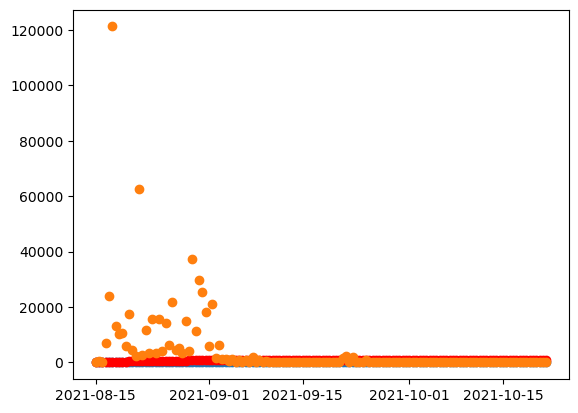

In [79]:
import seaborn as sns
plt.scatter(full_fr.t, full_fr.flinelen)
plt.scatter(full_fr.t, full_fr.farea, color = "red")
plt.scatter(full_fr.t, full_fr.sumFRP)

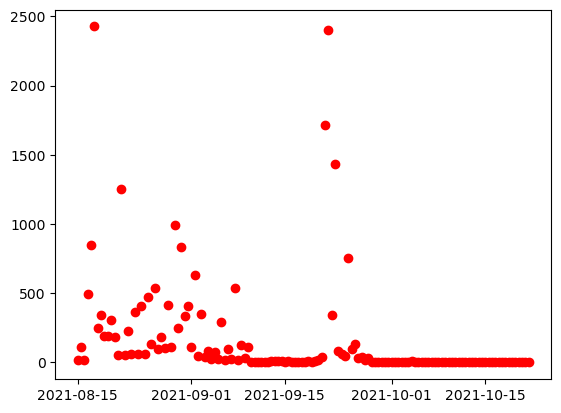

In [77]:
## Calculate sumFRP
no_zero = lambda a: max(a,1)
full_fr["sumFRP"] = full_fr.meanFRP * full_fr.n_newpixels.apply(no_zero) ## Note -- this might not be perfect. Code treats zeros differently, possible other exceptions.

## Calculate "fireline intensity" in units of MW/km (I think). (1000 kW / 1000 m or) kw/m
full_fr["intensity_fline"] = full_fr.sumFRP/full_fr.flinelen.apply(no_zero) ## There are cases where ther meanFRP > 0, so the sumFRP >0, but flinlen is 0, so sets this to infintie. (HOW CAN flinelen be 0 -- maybe involves differencing from previous????)
full_fr["intensity_fline"].unique()

plt.scatter(full_fr.t, full_fr.intensity_fline, color = "red") ## Puts equal weight on the early high-frp + small fire time periods and the late big-fire + low frp periods. Not sure how I feel about that

TypeError: 'method' object is not iterable

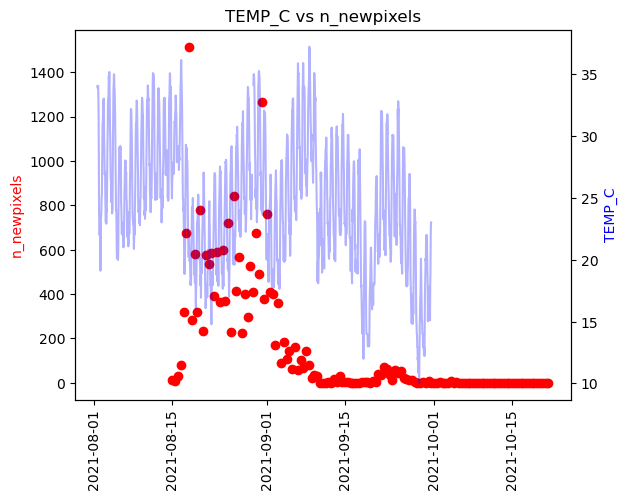

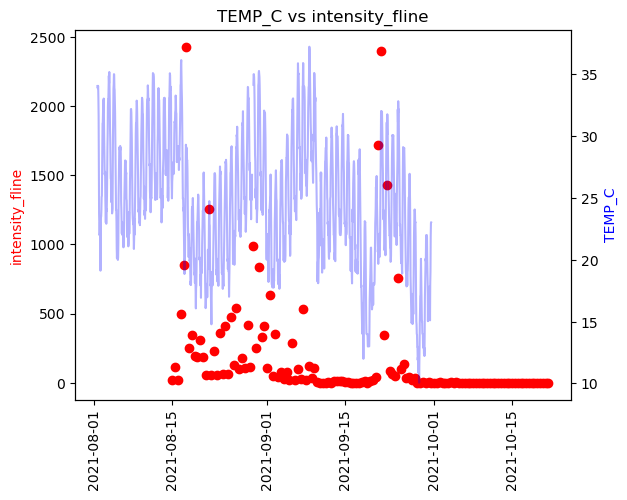

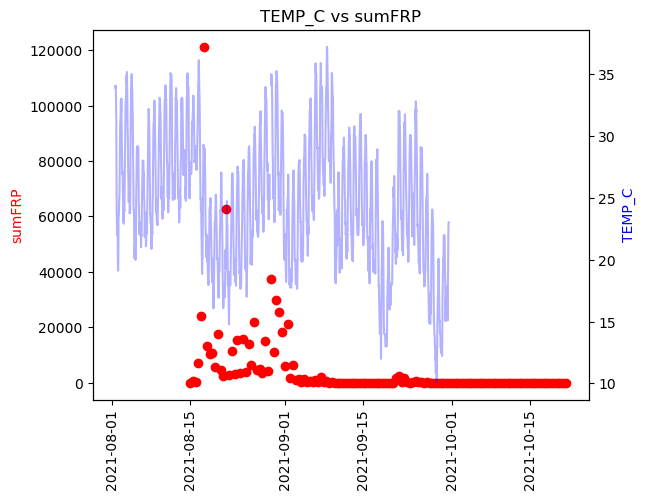

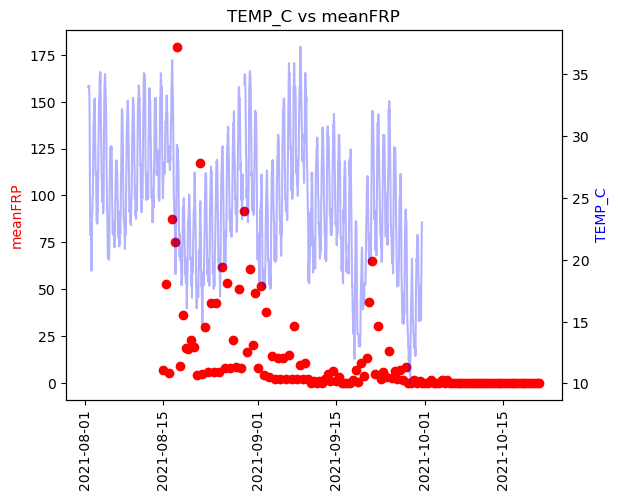

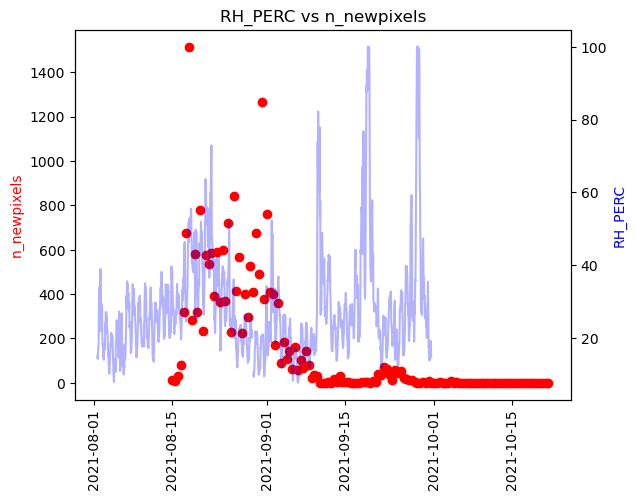

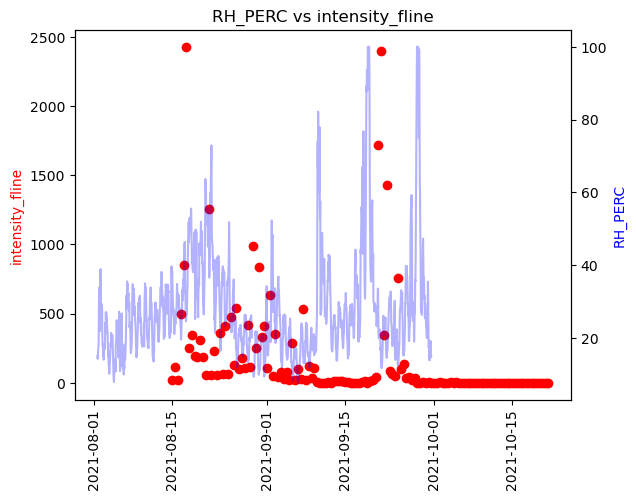

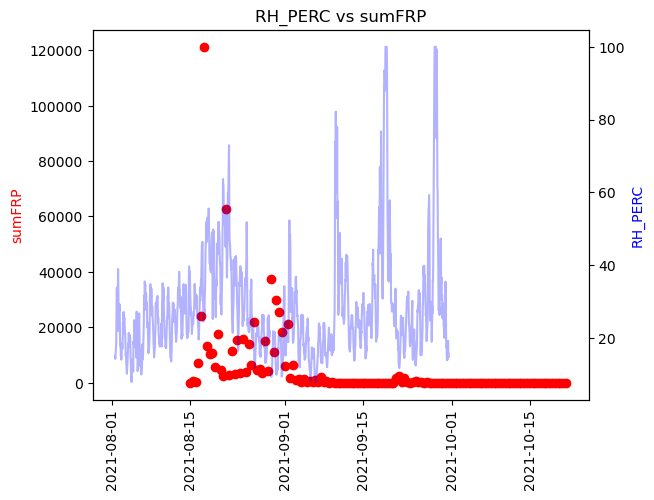

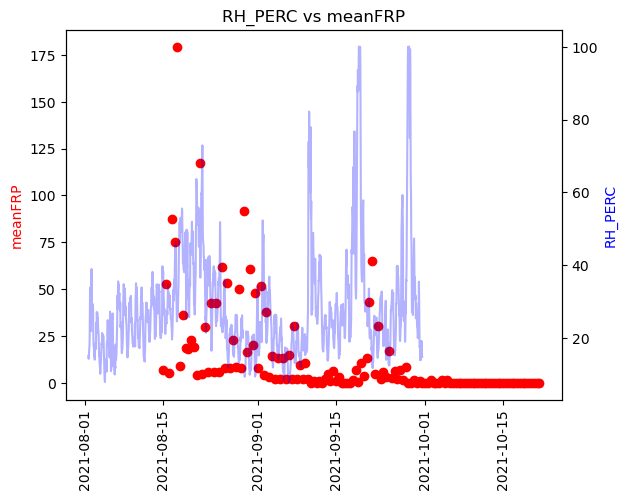

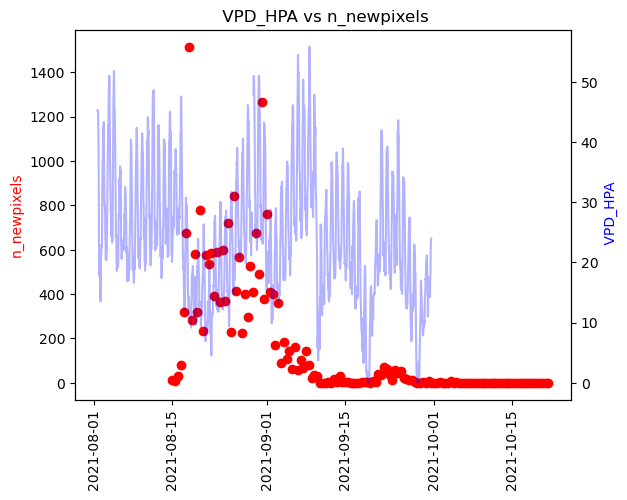

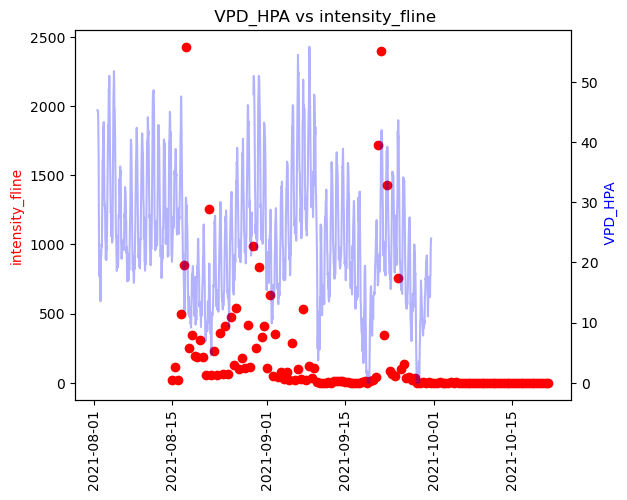

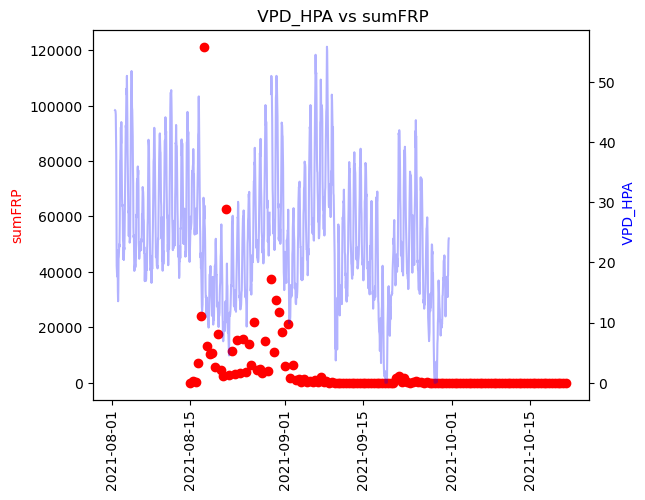

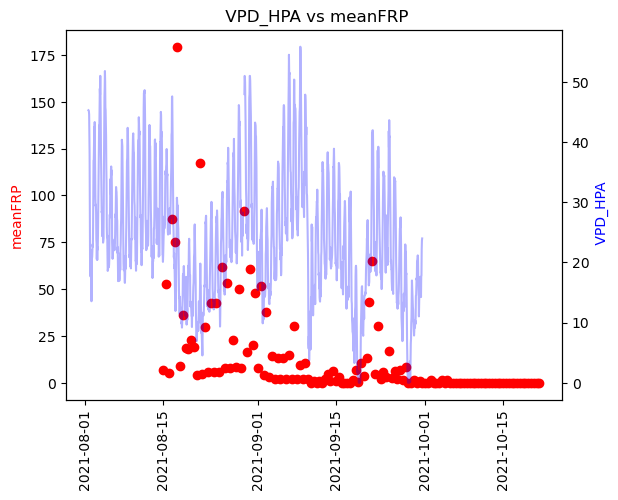

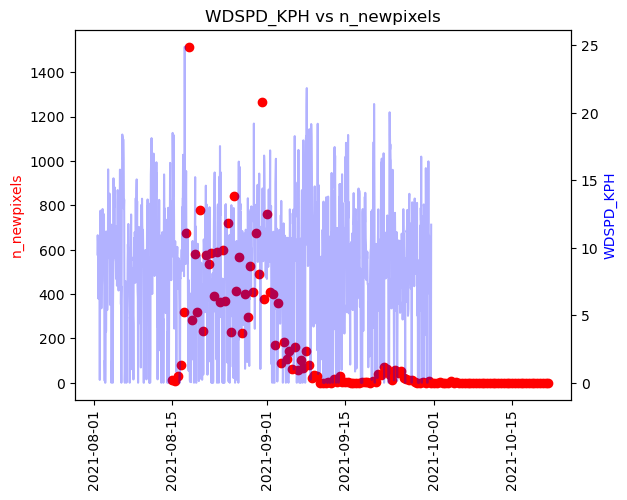

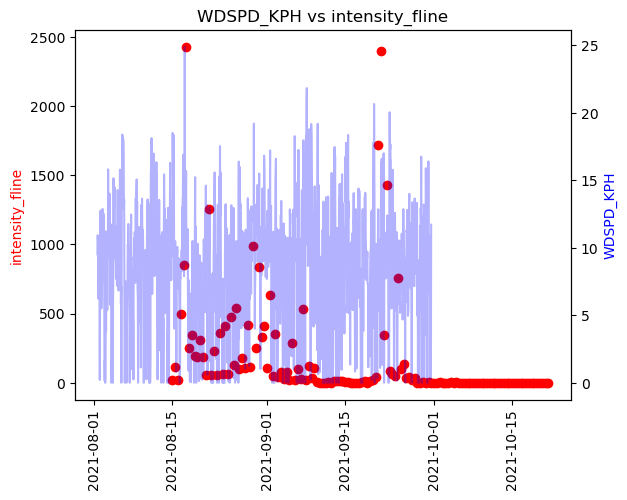

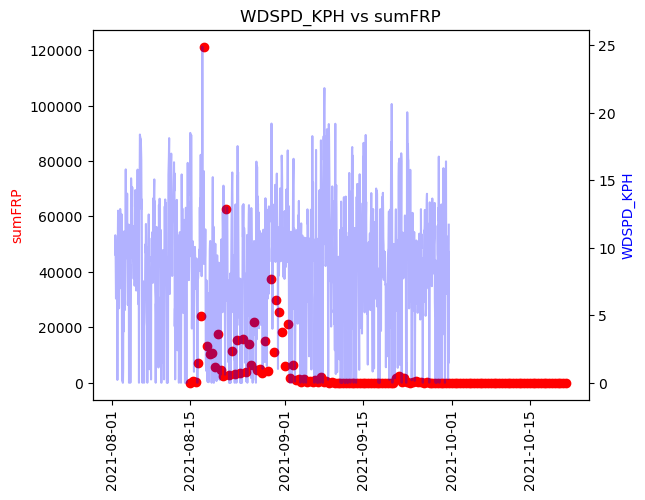

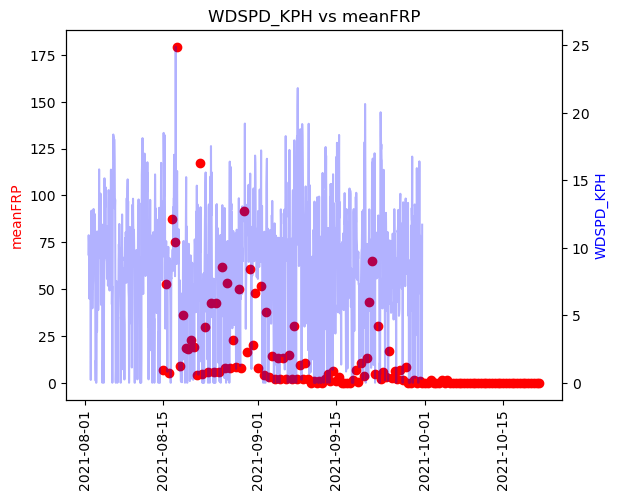

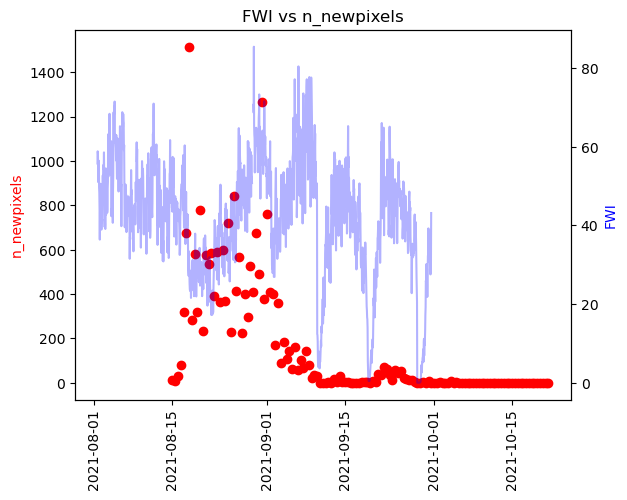

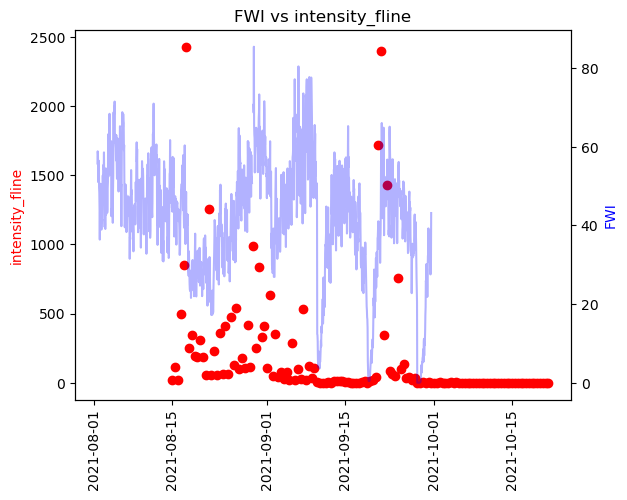

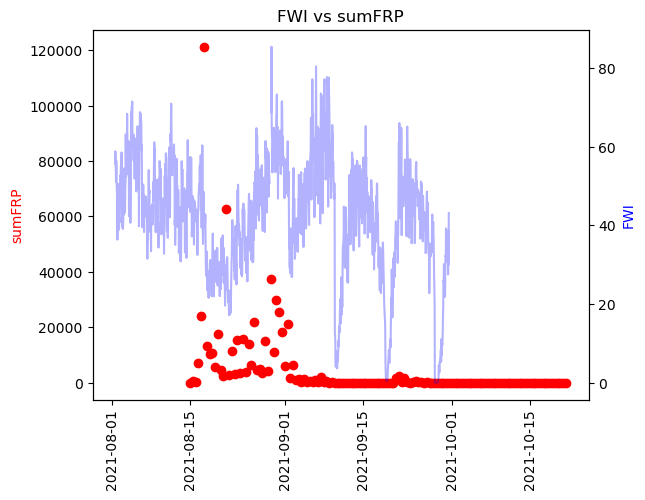

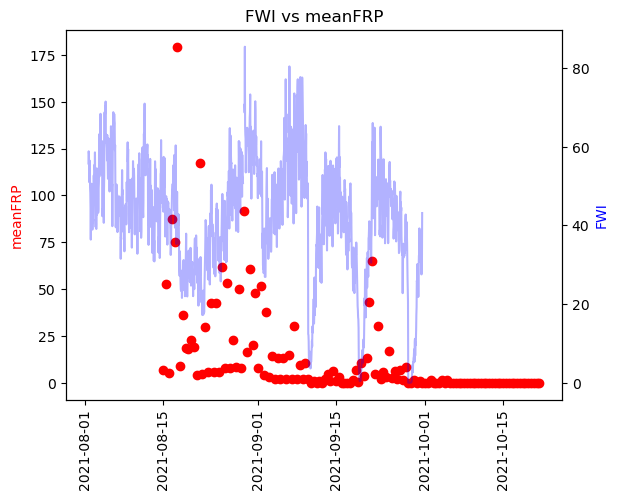

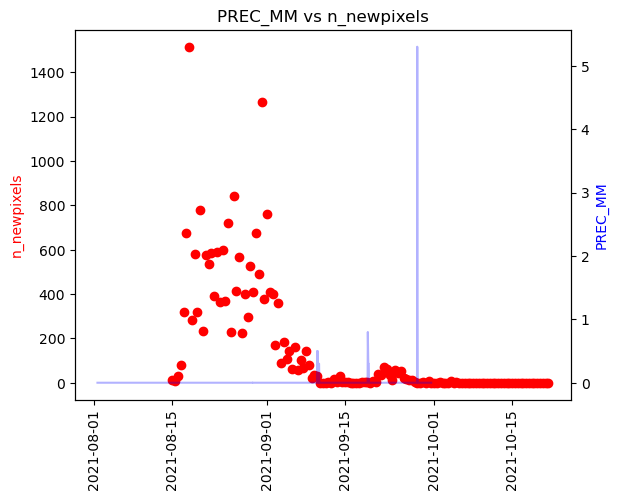

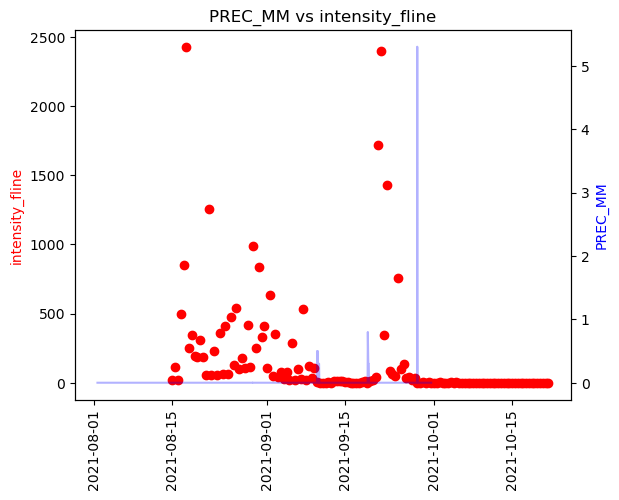

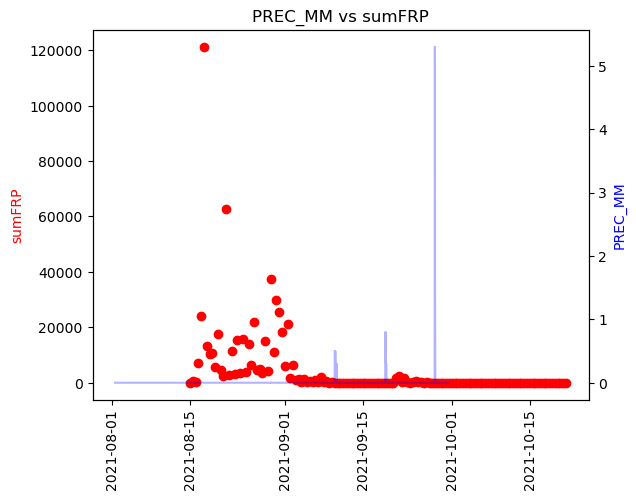

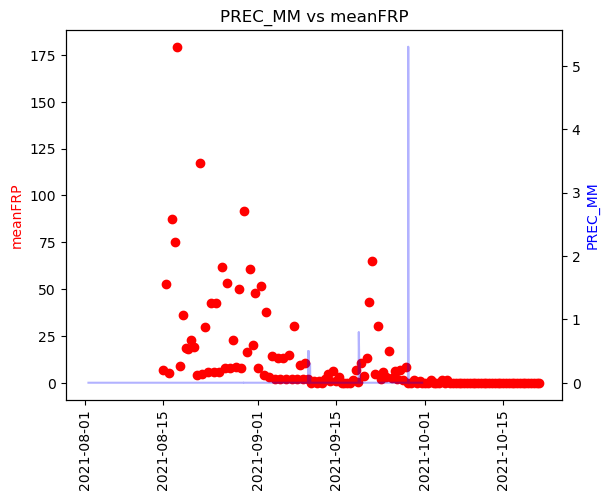

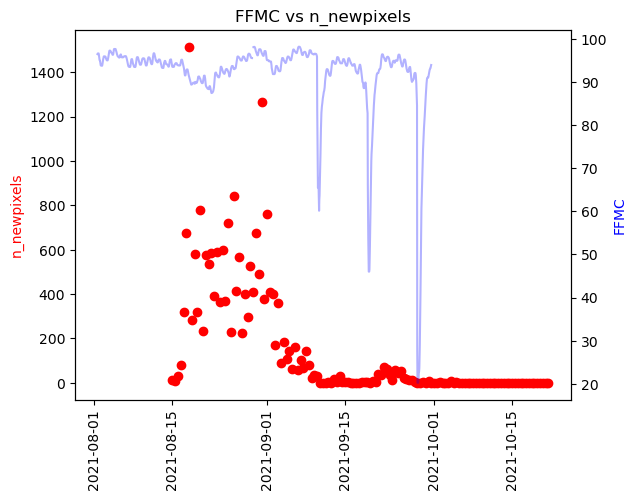

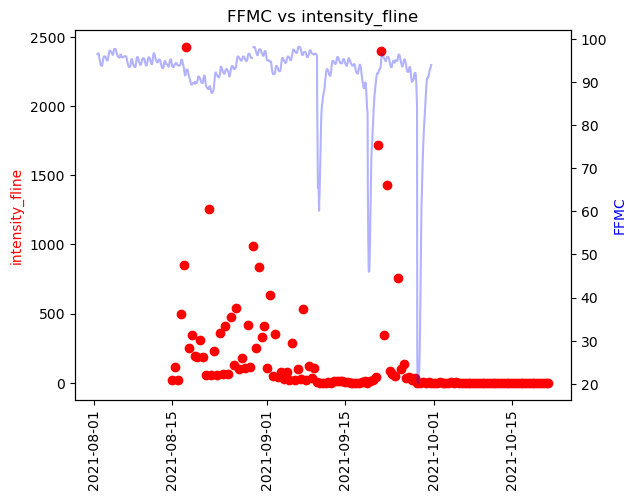

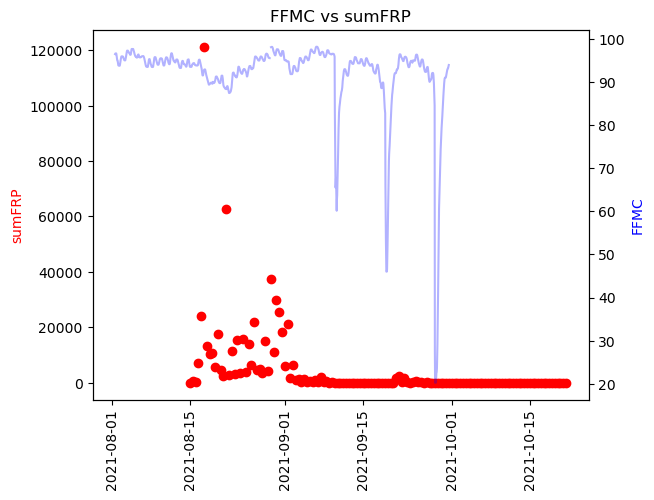

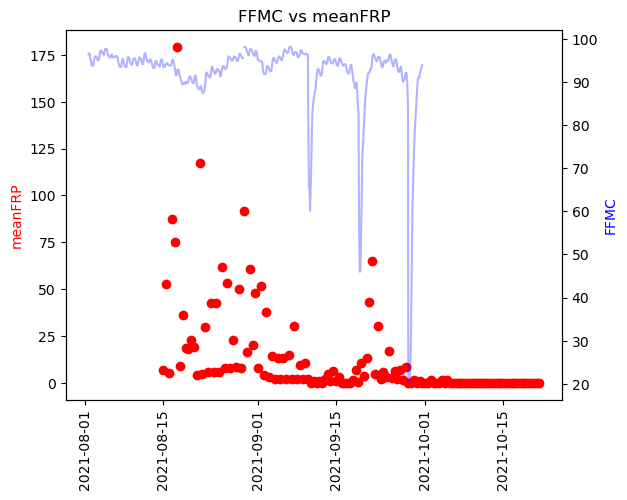

In [80]:
## Plot against precip


met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM', 'FFMC']  ## Station Data Columns to Plot
fire = [ 'n_newpixels', 'intensity_fline','sumFRP', 'meanFRP'] ## gdf columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue",  alpha=0.3)
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

In [86]:
## Calculate the theoretical amount of water per period
full_fr["intensity_kcal_s-m"] = full_fr.intensity_fline / 4.184
#full_fr



# heat capacity of air as it changes with tempurature
 I relied on this table from ohio: https://www.ohio.edu/mechanical/thermo/property_tables/air/air_Cp_Cv.html
 I fit their table of air temp and CP (heat capacity at standard pressure) to get a quick & dirty formula here: https://docs.google.com/spreadsheets/d/167VAt2TaCggGaHSQ0mJ30kclx0QG1J8WTVTYyAglW28/edit#gid=0 in units of kJ/kg @ K. 
 
 The equation was CP = 1.88 * 10^-4 Temp_c + 0.892
                   cf = cp/ 4.184  # Except that the paper used cf for 100 and 540 tempuratures. Unclear why. I will just use it's value
 
 CP kJ/kg, 1 kcal/4.184 kJ 
 
 Heat capacity of steam I took from the paper. 
 

In [97]:
def cal_quench_simp(I):
    depth_water = 3.84 * pow(I, (2/3)) * pow(10, (-4))
    return(depth_water) ## Returns mm of water

def cal_quench(I, 
               t_air, 
               t_eq = 100, # degrees c, temp that vaporizes all water
               t_f = 800, # degrees c
               flame_gas_density = 0.129 ## kg/m^3 assumed same heat capacity as air. 
               steam_heat_capacity = 0.46 # kcal/kg
               flame_heat_capacity = 0.264 # kcal/kg
              ):
    
    Hf = (t_f - t_eq) * flame_heat_capacity # heat from glame kcal/kg
    df = flame_gas_density * (273 / (t_f + 273)) # density of flame gas kcal/kg
    Vf = 0.00156 * pow(I, (4/3)) # volume of fire m^3/m (emperically derived scaling intensity with flame length)
    Hw = (100-t_air) + 540 + (t_eq - 100) * steam_heat_capacity # Heat absorbed by water kcal/kg
    Ww = (Hf * Wf) / Hw # Weight of water kg/m of front
    Dw = Ww/ (0.0792 * pow(I, (2/3))) # depth of water in 
    
    return(Dw)
    

#def cal_cool(I, w_1): # w_1 is weight of fule in kg/m2. 0 idea how to estimate that. Maybe LAI from LIS? Maybe they give a biomass metric? 
    
    
    
full_fr["quenching_mm"] = full_fr["intensity_kcal_s-m"].apply(cal_quench)
#full_fr["quenching_units"].unique()
#full_fr["cooling_mm"]


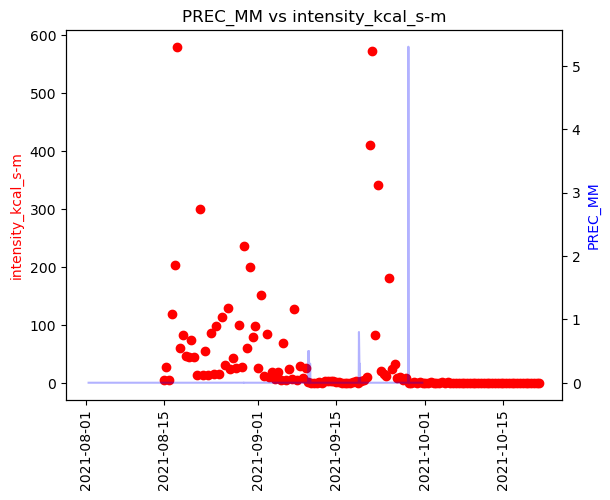

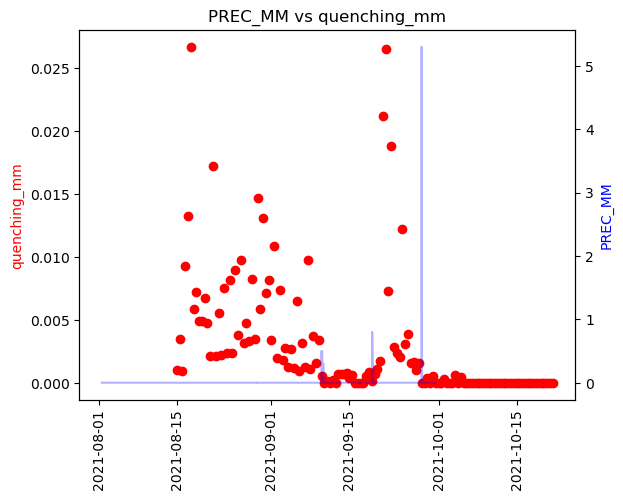

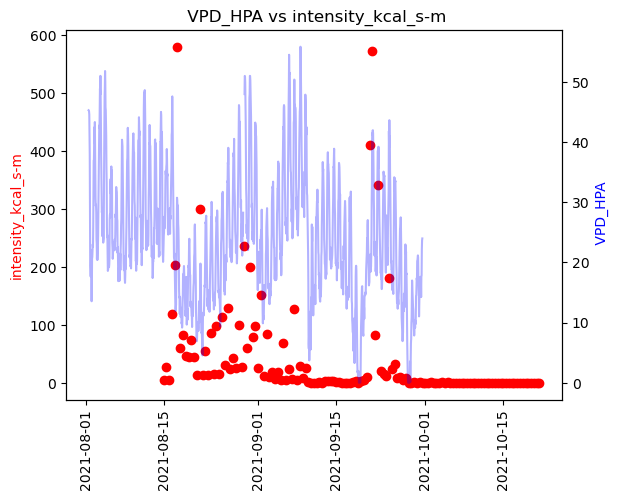

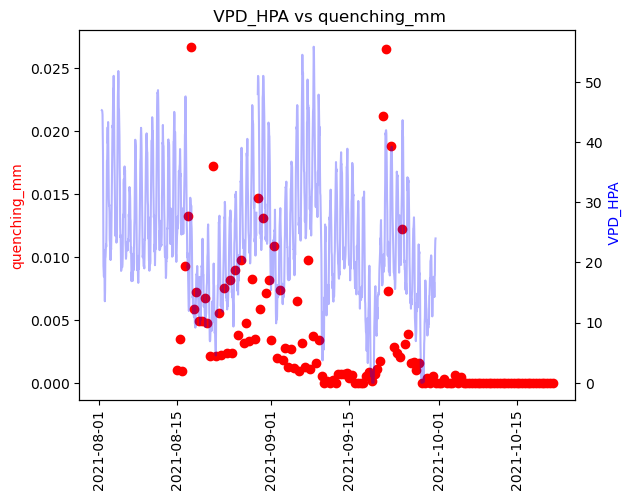

In [101]:
met = ['PREC_MM', ' VPD_HPA']  ## Station Data Columns to Plot
fire = [  "intensity_kcal_s-m","quenching_mm" ] ## gdf columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue",  alpha=0.3)
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

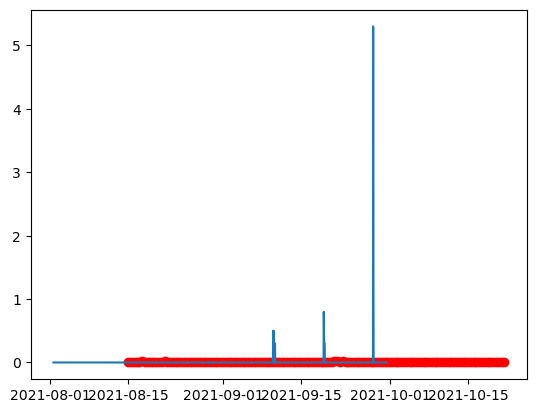

In [100]:
plt.scatter(full_fr.t, full_fr.quenching_units, color = "red")
plt.plot(full_fr.t, full_fr.PREC_MM)

In [91]:
#s3.ls("s3://veda-data-store-staging/EIS/COG/")

['veda-data-store-staging/EIS/COG/.fuse_hidden000000b400000001',
 'veda-data-store-staging/EIS/COG/Fire-Hydro',
 'veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US',
 'veda-data-store-staging/EIS/COG/LIS_GLOBAL_DA',
 'veda-data-store-staging/EIS/COG/LIS_HIST_202001010000.d01.cog.tif',
 'veda-data-store-staging/EIS/COG/LIS_TWS_ANOMALY',
 'veda-data-store-staging/EIS/COG/LIS_TWS_TREND',
 'veda-data-store-staging/EIS/COG/LIS_WEST_US_DA',
 'veda-data-store-staging/EIS/COG/OCO2_GEOS_L3CO2_day',
 'veda-data-store-staging/EIS/COG/SSH_2017_minus_1992.cog.tif',
 'veda-data-store-staging/EIS/COG/bs_to_save.tif',
 'veda-data-store-staging/EIS/COG/caldor_perimeter_separated_ts.geojson',
 'veda-data-store-staging/EIS/COG/caldor_perimeter_ts.geojson',
 'veda-data-store-staging/EIS/COG/caldor_pixel_ts.geojson',
 'veda-data-store-staging/EIS/COG/coastal-flooding-and-slr',
 'veda-data-store-staging/EIS/COG/frp_to_save.tif']

In [94]:
#s3.ls("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/")

['veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/GPP_ANOM',
 'veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/GPP_PCTL',
 'veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/PRECIP',
 'veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM']

In [95]:
#s3.ls("s3://veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/")

['veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/BUI',
 'veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/DC',
 'veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/DMC',
 'veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/FFMC',
 'veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/FWI',
 'veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/ISI']